# Two implementations of the model:
#         1. mother cell   
#         2. mother cell + bud; several generations

    

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from math import pi
from copy import deepcopy

In [2]:
#################################
'''simulation mother'''
#################################

ce = 240
R = 8.314
T = 303
Lp = 1.19*10**(-6)
d = 0.115
phi = 10**(-4)
pi_tc = 0.2*10**6
nu = 0.5
k_uptake = 0.2
k_consumption = 0.25
modulus_adjustment = (1-nu**2)**(-1)
E3d = 2.58*10**6
E = modulus_adjustment * E3d

para = (ce,R,T,Lp,d,phi,pi_tc,nu,k_uptake,k_consumption,E)

#initial values
r_os = 0.1
r_b = 0.3
r = r_os + r_b
c_i = 319.17
pi_t = 0.2*10**(6)
R_ref = r/(1 + (1 - nu) * (pi_t * r) / (E * 2 * d))
initial_values_1 = [r_os, r_b, r, R_ref, c_i, pi_t]


def ODE_1(t,y,para):
    #parameter
    c_e = para[0]
    R = para[1]
    T = para[2]
    Lp = para[3]
    d = para[4]
    phi = para[5]
    pi_tc = para[6]
    nu = para[7]
    k_uptake = para[8]
    k_consumption = para[9]
    E = para[10]
  
    #integration variables
    r_os = y[0]
    r_b = y[1]
    r = y[2]
    R_ref = y[3]
    c_i = y[4]
    pi_t = y[5]
    
    #dependent variables
    V_tot_fl = 4 / 3 * pi * r**3
    V_ref = 4 /3 * pi * R_ref**3
    G = 4*pi*r**2
    pi_i = c_i * R * T
    pi_e = c_e * R * T
    G = 4*pi*r**2
    plastic_expansion = max(pi_t - pi_tc,0)    
    
    #derivatives of integration variables 
    dr_os = - Lp *(pi_t + (pi_e - pi_i))
    dR_ref = phi * R_ref * r / (2 * d)*plastic_expansion
    dr_b = dR_ref * 0.2
    dr = dr_os + dr_b
    dc_i = 3*k_uptake/r - k_consumption - 3*c_i*dr/r
    dpi_t = E * 2 * d / (1-nu) * (dr/r**2 - dR_ref/(R_ref*r)) - dr / r * pi_t


    f = [dr_os, dr_b, dr, dR_ref, dc_i, dpi_t]           
    return f

#solving and result preparation
dur = 10000
t1 = np.linspace(0, dur, int(dur/100))
sol1 = solve_ivp(lambda t,y:ODE_1(t,y,para), [0, dur], initial_values_1, method='BDF',t_eval=t1,dense_output=True) 


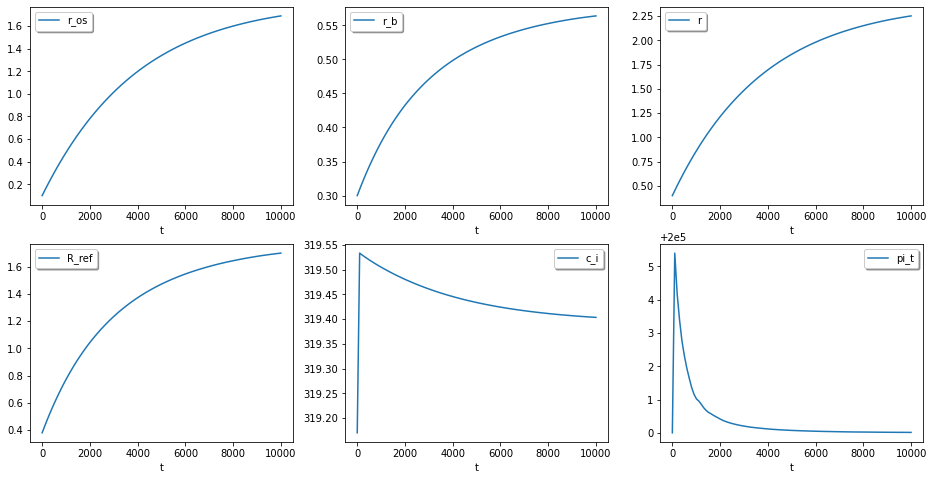

In [3]:
results_1 = sol1.sol(t1)

#plotting

fig,ax = plt.subplots(2,3,figsize=(16,8))
ax[0,0].plot(t1,results_1[0])
ax[0,1].plot(t1, results_1[1])
ax[0,2].plot(t1, results_1[2])
ax[1,0].plot(t1, results_1[3])
ax[1,1].plot(t1, results_1[4])
ax[1,2].plot(t1, results_1[5])

ax[0,0].set_xlabel('t')
ax[0,1].set_xlabel('t')
ax[0,2].set_xlabel('t')
ax[1,0].set_xlabel('t')
ax[1,1].set_xlabel('t')
ax[1,2].set_xlabel('t')


ax[0,0].legend(['r_os'], shadow=True)
ax[0,1].legend(['r_b'], shadow=True)
ax[0,2].legend(['r'], shadow=True)
ax[1,0].legend(['R_ref'], shadow=True)
ax[1,1].legend(['c_i'], shadow=True)
ax[1,2].legend(['pi_t'], shadow=True)

plt.show()

In [96]:
###########################################################
'''simulation mother + daughter_____multiple generations'''
###########################################################
#parameter values
scale_factor_pi_t = 10**6
scale_factor_ci = 10**3
ce = 240/scale_factor_ci
R = 8.314
T = 303
Lp = 1.19*10**(-6) * scale_factor_pi_t
d = 0.115
phi = 1*10**(-4) * scale_factor_pi_t
pi_tc = 0.2*10**6 / scale_factor_pi_t
nu = 0.5
k_uptake = 0.2 / scale_factor_ci * 3.
k_consumption = 0.25 / scale_factor_ci
modulus_adjustment = (1-nu**2)**(-1)
E3d = 2.58*10**6 / scale_factor_pi_t
E = modulus_adjustment * E3d #*1.1

phi_d = phi * 100
E_d =  E *1.28
c_diff = 1. #.000001
w_diff =  1. * scale_factor_pi_t #* 0.0000001

cell_phase = 'G1' #this is just the start value; gets changed whenever the cell phase changes;

para = [ce,R,T,Lp,d,phi,pi_tc,nu,k_uptake,k_consumption,E,phi_d,E_d,c_diff,w_diff,cell_phase]

#initial values
#mother
r_os = .1
r_b = .3
r = r_os + r_b
c_i = 319.17 / scale_factor_ci
pi_t = 0.2*10**(6) / scale_factor_pi_t
R_ref = r/(1 + (1 - nu) * (pi_t * r) / (E * 2 * d))

#daughter
r_os_d = .1
r_b_d = .3
r_d = r_os_d + r_b_d
c_i_d = 319.17 / scale_factor_ci
pi_t_d = 0.2*10**(6) / scale_factor_pi_t
R_ref_d = r_d/(1 + (1 - nu) * (pi_t_d * r_d) / (E_d * 2 * d))

t_in_G1 = 0
t_in_G2 = 0

initial_values_m = [r_os, r_b, r, R_ref, c_i, pi_t]
initial_values_d = [r_os_d, r_b_d, r_d, R_ref_d, c_i_d, pi_t_d]
initial_values_timing = [t_in_G1, t_in_G2]

#utility functions
def print_it(functions, values):
    for f,v in zip(functions,values):
        print(f, ' ', v)
    print(' ')
    print(' ')
    return None
 
#functions for calculation
def water_diffusion(w_diff,pi_t,pi_t_d,V_tot_fl,V_tot_fl_d,r,r_d):  
    dV_exchange = - w_diff*(pi_t - pi_t_d)
    dV_exchange_d = + w_diff*(pi_t - pi_t_d)
    
    dV = V_tot_fl + dV_exchange
    dV_d = V_tot_fl_d + dV_exchange_d
    
    if dV < 0:
        dr_exchange = -(-dV*3/4/pi)**(1/3) - r
    else:
        dr_exchange = (dV*3/4/pi)**(1/3) - r
    if dV_d < 0:
        dr_exchange_d = -(-dV_d*3/4/pi)**(1/3) - r_d
    else:
        dr_exchange_d = (dV_d*3/4/pi)**(1/3) - r_d
    return dr_exchange,dr_exchange_d


def osmolyte_diffusion(c_diff, c_i, c_i_d, V_tot_fl, V_tot_fl_d):
    dc_i_diff = - c_diff*(c_i - c_i_d)/V_tot_fl
    dc_i_diff_d = + c_diff*(c_i - c_i_d)/V_tot_fl_d
    return dc_i_diff, dc_i_diff_d

G1_duration = 3000
G2_duration = 5000

#events
def change_cell_phase(t,y,para): 
    if para[15] == 'G1':
        return y[12]-G1_duration
    if para[15] =='G2':
        return y[13]-G2_duration
change_cell_phase.terminal = True


#after event
def get_ini_val(sol,para,var_nr,initial_values_d):  
    #get mother values from last cell phase
    ini_val_m = []
    for i in range(var_nr):
        ini_val_m.append(sol.y[i][-1])
    
    #get daughter values from given initial_values
    ini_val_d = deepcopy(initial_values_d)
    
    if para[15] == 'G1':
        #adjust cell phase
        para[15] = 'G2'
        #set initial osmolyte concentration and internal tugor pressure of daughter 
        #to vaule of mother (c_i_d, pi_t_d -> c_i, pi_t)
        ini_val_d[4] = sol.y[4][-1]
        ini_val_d[5] = sol.y[5][-1]
    elif para[15] == 'G2':
        #adjust cell phase
        para[15] = 'G1'  
        #reduce extensibility of mother with each generation (budscares etc.)
        para[5] = .7 * para[5]
    
    #reset G1/G2 timing variables
    ini_val_timing = [0,0]
    
    #assemble initial values for next integration
    ini_val = ini_val_m + ini_val_d + ini_val_timing
    
    return ini_val


#solver function with ODEs
def ODE_2(t,y,para):
    #integration variables
    r_os = y[0]
    r_b = y[1]
    r = y[2]
    R_ref = y[3]
    c_i = y[4]
    pi_t = y[5]
    
    r_os_d = y[6]
    r_b_d = y[7]
    r_d = y[8]
    R_ref_d = y[9]
    c_i_d = y[10]
    pi_t_d = y[11]
    
    #timing variables 
    t_in_G1 = y[12] 
    t_in_G2 = y[13]
    
    #parameters
    c_e = para[0]
    R = para[1]
    T = para[2]
    Lp = para[3]
    d = para[4]
    phi = para[5]
    pi_tc = para[6]
    nu = para[7]
    k_uptake = para[8]
    k_consumption = para[9]
    E = para[10]
    
    phi_d = para[11]    #para[5] + para[11]*(1-(t-1)/G2_duration)
    E_d = para[12]
    c_diff = para[13]
    w_diff = para[14]
    
    cell_phase = para[15]
    
    
    #dependent variables
    V_tot_fl = 4 / 3 * pi * r**3
    V_ref = 4 /3 * pi * R_ref**3
    G = 4*pi*r**2
    pi_i = c_i * R * T * scale_factor_ci / scale_factor_pi_t
    pi_e = c_e * R * T * scale_factor_ci / scale_factor_pi_t
    plastic_expansion = max(pi_t - pi_tc,0) 
    
    V_tot_fl_d = 4 / 3 * pi * r_d**3
    V_ref_d = 4 /3 * pi * R_ref_d**3
    G_d = 4*pi*r_d**2
    pi_i_d = c_i_d * R * T * scale_factor_ci / scale_factor_pi_t
    plastic_expansion_d = max(pi_t_d - pi_tc,0)
    
    #derivatives 
    if cell_phase == 'G1':
        #derivatives of variables
        dr_os = - Lp *(pi_t + (pi_e - pi_i)) 
        dR_ref = phi * R_ref * r / (2 * d)*plastic_expansion
        dr_b = dR_ref * 0.2
        dr = dr_os + dr_b
        dc_i = 3*k_uptake/r - k_consumption - 3*c_i*dr/r
        dpi_t = E * 2 * d / (1-nu) * (dr/r**2 - dR_ref/(R_ref*r)) - dr / r * pi_t
        
        dr_os_d = 0
        dR_ref_d = 0
        dr_b_d = 0
        dr_d = 0
        dc_i_d = 0
        dpi_t_d = 0
        
        #derivatives of timing variables
        dt_in_G1 = 1
        dt_in_G2 = 0

    
    if cell_phase == 'G2':
        #support derivatives
        dr_ex = water_diffusion(w_diff,pi_t,pi_t_d,V_tot_fl,V_tot_fl_d,r,r_d)
        dr_exchange = dr_ex[0]
        dr_exchange_d = dr_ex[1]
    
        dc_diff = osmolyte_diffusion(c_diff, c_i, c_i_d, V_tot_fl, V_tot_fl_d)
        dc_i_diff = dc_diff[0]
        dc_i_diff_d = dc_diff[1]
        
        #derivatives of variables
        dr_os = - Lp *(pi_t + (pi_e - pi_i)) + dr_exchange
        dR_ref = phi * R_ref * r / (2 * d)*plastic_expansion
        dr_b = dR_ref * 0.2
        dr = dr_os + dr_b
        dc_i = 3*k_uptake/r - k_consumption - 3*c_i*dr/r + dc_i_diff
        dpi_t = E * 2 * d / (1-nu) * (dr/r**2 - dR_ref/(R_ref*r)) - dr / r * pi_t
        
        dr_os_d = - Lp *(pi_t_d + (pi_e - pi_i_d)) + dr_exchange_d
        dR_ref_d = phi_d * R_ref_d * r_d / (2 * d)*plastic_expansion_d
        dr_b_d = dR_ref_d * 0.2
        dr_d = dr_os_d + dr_b_d
        dc_i_d = 3*k_uptake/r_d - k_consumption - 3*c_i_d*dr_d/r_d + dc_i_diff_d
        dpi_t_d = E_d * 2 * d / (1-nu) * (dr_d/r_d**2 - dR_ref_d/(R_ref_d*r_d)) - dr_d / r_d * pi_t_d

        #derivatives of timing variables
        dt_in_G1 = 0
        dt_in_G2 = 1
    
    f = [dr_os, dr_b, dr, dR_ref, dc_i, dpi_t, dr_os_d, 
         dr_b_d, dr_d, dR_ref_d, dc_i_d, dpi_t_d,dt_in_G1,dt_in_G2] 

    return f

#solving and result preparation

#dur = 0  #total duration of simulation

solutions = []   #output of solve_ivp gets stored here
real_dur = []   #actual duration of each simulation round gets stored here   
ini_val = initial_values_m + initial_values_d + initial_values_timing
run_nr = 0
cycle_nr = 9
if cycle_nr == 0:
    one_more = False
else:
    one_more = True

#first G1 phase
first_dur = 5000

sol = solve_ivp(ODE_2, [0, first_dur], ini_val, method='BDF',
                    args=[para],dense_output=True,max_step=1.)
print('this was run number %d' %run_nr)
#save solution
solutions.append(sol)  
var_nr = len(initial_values_m)   #number of 'mother' variables
ini_val = get_ini_val(sol,para,var_nr,initial_values_d)   #prepare new strting values
while one_more:
    run_nr += 1
    #remaining_dur = dur - sum(real_dur)   #maximum duration of the next simulation
    remaining_dur = max(G1_duration,G2_duration) + 1
    #solve:
    sol = solve_ivp(ODE_2, [0, remaining_dur], ini_val, method='BDF',
                    args=[para],dense_output=True,events = change_cell_phase,max_step=1.) 
    print('this was run number %d' %run_nr)
    #save solution
    solutions.append(sol)
    
    var_nr = len(initial_values_m)   #number of 'mother' variables
    ini_val = get_ini_val(sol,para,var_nr,initial_values_d)   #prepare new strting values
    
    G2_duration = G2_duration/0.92
    #real_dur.append(sol.t[-1])   
    #if dur - sum(real_dur) <= 1:   #check if end of simulation time is reached (errors
    #    one_more = False           #occur if remaining simulation time is less than 1)
    if run_nr == cycle_nr*2-1:
        one_more = False
    
        
last_dur = 0

sol = solve_ivp(ODE_2,[0,last_dur],ini_val,method='BDF',args=[para],dense_output=True,max_step=1.)
solutions.append(sol)
    

this was run number 0
this was run number 1
this was run number 2
this was run number 3
this was run number 4
this was run number 5
this was run number 6
this was run number 7
this was run number 8
this was run number 9
this was run number 10
this was run number 11
this was run number 12
this was run number 13
this was run number 14
this was run number 15
this was run number 16
this was run number 17


In [97]:
#process results

def concatenate_res(res_t,res_y,sol):
    res_t = np.concatenate([res_t,sol.t + res_t[-1]])
    
    for i in range(len(sol.y)):
        res_y[i] = np.concatenate([res_y[i],sol.y[i]])
    
    res = [res_t] + res_y
    return res_t,res_y


#initialize np arrays with initial_values 
res_t = np.zeros(2)
ini_val = initial_values_m + initial_values_d + initial_values_timing
res_y = []
for s in ini_val:
    res_y.append(np.array((s,s)))
for i in range(len(solutions)):
    if len(res_y) == len(solutions[i].y):
        res_t,res_y = concatenate_res(res_t,res_y,solutions[i])        
    else:
        print('solutions must have the same number of variables to concatenate!')
        raise ValueError 


In [98]:
#calculate c_i - c_i_d
delta_ci = res_y[4]-res_y[10]

#calculate pi_t - pi_t_d
delta_pi_t = res_y[5]- res_y[11]
for i in range(len(delta_pi_t)):
    if delta_pi_t[i] > 5:
        delta_pi_t[i] = 5
    if delta_pi_t[i] < -5:
        delta_pi_t[i] = -5
        
#line at zero
zero = np.zeros(len(res_t))

#water diffusion
dr_exchange = []
dr_exchange_d = []
for pi_t,pi_t_d,r,r_d in zip(res_y[5],res_y[11],res_y[2],res_y[8]):
    V_tot_fl = 4 / 3 * pi * r**3
    V_tot_fl_d = 4 / 3 * pi * r_d**3
    dr,dr_d = water_diffusion(w_diff,pi_t,pi_t_d,V_tot_fl,V_tot_fl_d,r,r_d)
    dr_exchange.append(dr)
    dr_exchange_d.append(dr_d)
    
#osmolyte diffusion
dc_diff = []
dc_diff_d = []
for c_i,c_i_d,r,r_d in zip(res_y[4],res_y[10],res_y[2],res_y[8]):
    V_tot_fl = 4 / 3 * pi * r**3
    V_tot_fl_d = 4 / 3 * pi * r_d**3
    dc_i, dc_i_d = osmolyte_diffusion(c_diff, c_i, c_i_d, V_tot_fl, V_tot_fl_d)
    dc_diff.append(dc_i)
    dc_diff_d.append(dc_i_d)
    
for i in range(len(res_t)):
    if res_y[6][i] == 0.1:
        delta_ci[i] = 0
        delta_pi_t[i] = 0
        dr_exchange[i] = 0
        dr_exchange_d[i] = 0
        dc_diff[i] = 0
        dc_diff_d[i] = 0

#cell density
cell_dens = []
cell_dens_d = []
for r_b,r, r_b_d,r_d in zip(res_y[1],res_y[2], res_y[7],res_y[8]):
    V_b = 4 / 3 * pi * r_b**3
    V_tot_fl = 4 / 3 * pi * r**3
    dens = V_b/V_tot_fl
    cell_dens.append(dens)
    
    V_b_d = 4 / 3 * pi * r_b_d**3
    V_tot_fl_d = 4 / 3 * pi * r_d**3
    dens_d = V_b_d/V_tot_fl_d
    cell_dens_d.append(dens_d)
    
#calculate means
delta_ci_mean = np.array(delta_ci).mean()
delta_pi_t_mean = np.array(delta_pi_t).mean()
dr_exchange_mean = np.array(dr_exchange).mean()
dr_exchange_d_mean = np.array(dr_exchange_d).mean()
dc_diff_mean = np.array(dc_diff).mean()
dc_diff_d_mean = np.array(dc_diff_d).mean()
cell_dens_mean = np.array(cell_dens).mean()
cell_dens_d_mean = np.array(cell_dens_d).mean()

print(delta_ci_mean ,delta_pi_t_mean ,dr_exchange_mean ,
      dr_exchange_d_mean ,dc_diff_mean ,dc_diff_d_mean ,cell_dens_mean ,cell_dens_d_mean  )

for i in range(len(res_t)):
    for val_list,mean in zip([delta_ci,delta_pi_t,dr_exchange,dr_exchange_d ,dc_diff,dc_diff_d,cell_dens,cell_dens_d],
                        [delta_ci_mean ,delta_pi_t_mean ,dr_exchange_mean ,dr_exchange_d_mean 
                     ,dc_diff_mean ,dc_diff_d_mean ,cell_dens_mean ,cell_dens_d_mean]):
        if val_list[i]**2 > (mean*1)**2:
            if val_list[i] > 0:
                val_list[i] = ((mean*1)**2)**.5
            elif val_list[i] < 0:
                val_list[i] = -((mean*1)**2)**.5

                
'''#make small changes in r visible
for i in range(len(res_y[2])):
    if res_y[2][i] < 7.5:
        res_y[2][i] = 7.5'''

#derivatives
#parameters
c_e = para[0]
R = para[1]
T = para[2]
Lp = para[3]
d = para[4]
phi = para[5]
pi_tc = para[6]
nu = para[7]
k_uptake = para[8]
k_consumption = para[9]
E = para[10]

phi_d = para[11]    #para[5] + para[11]*(1-(t-1)/G2_duration)
E_d = para[12]
c_diff = para[13]
w_diff = para[14]

cell_phase = para[15]

res_dr_os = []
res_dR_ref = []
res_dr_b = []
res_dr = []
res_dc_i = []
res_dn_i = []
res_dc_dilution = []
res_dpi_t = []
res_dpi_t_elastic = []
res_dpi_t_plastic = []

#integration variables
for i in range(len(res_y[0])):
    r_os = res_y[0][i]
    r_b = res_y[1][i]
    r = res_y[2][i]
    R_ref = res_y[3][i]
    c_i = res_y[4][i]
    pi_t =res_y[5][i]

    r_os_d = res_y[6][i]
    r_b_d = res_y[7][i]
    r_d = res_y[8][i]
    R_ref_d = res_y[9][i]
    c_i_d = res_y[10][i]
    pi_t_d = res_y[11][i]

    #timing variables 
    t_in_G1 = res_y[12][i] 
    t_in_G2 = res_y[13][i]

    #dependent variables
    V_tot_fl = 4 / 3 * pi * r**3
    V_ref = 4 /3 * pi * R_ref**3
    G = 4*pi*r**2
    pi_i = c_i * R * T * scale_factor_ci / scale_factor_pi_t
    pi_e = c_e * R * T * scale_factor_ci / scale_factor_pi_t
    plastic_expansion = max(pi_t - pi_tc,0) 

    V_tot_fl_d = 4 / 3 * pi * r_d**3
    V_ref_d = 4 /3 * pi * R_ref_d**3
    G_d = 4*pi*r_d**2
    pi_i_d = c_i_d * R * T * scale_factor_ci / scale_factor_pi_t
    plastic_expansion_d = max(pi_t_d - pi_tc,0)

    #derivatives 
    #derivatives of variables
    dr_os = - Lp *(pi_t + (pi_e - pi_i)) 
    dR_ref = phi * R_ref * r / (2 * d)*plastic_expansion
    dr_b = dR_ref * 0.2
    dr = dr_os + dr_b
    dn_i = 3*k_uptake/r - k_consumption 
    dc_dilution = - 3*c_i*dr/r*(-1)
    dpi_t_elastic = E * 2 * d / (1-nu) * (dr/r**2 ) - dr / r * pi_t
    dpi_t_plastic = E * 2 * d / (1-nu) * (- dR_ref/(R_ref*r))
    dc_i = 3*k_uptake/r - k_consumption - 3*c_i*dr/r
    dpi_t = E * 2 * d / (1-nu) * (dr/r**2 - dR_ref/(R_ref*r)) - dr / r * pi_t
 
    if dr > 1*10**(-4):
        dr = 10**(-4)
    elif dr < -1*10**(-4):
        dr = -10**(-4)

    if dn_i > 1*10**(-4):
        dn_i = 1*10**(-4)
    elif dn_i < - 1*10**(-4):
        dn_i = - 1*10**(-4)
    if dc_dilution > 1*10**(-4):
        dc_dilution = 1*10**(-4)
    elif dc_dilution < 0:
        dc_dilution = 0
    
    if dpi_t_elastic > 1*10**(-7):
        dpi_t_elastic = 1*10**(-7)
    elif dpi_t_elastic < - 1*10**(-7):
        dpi_t_elastic = - 1*10**(-7)
    if dpi_t_plastic > 1*10**(-7):
        dpi_t_plastic = 1*10**(-7)
    elif dpi_t_plastic < - 1*10**(-7):
        dpi_t_plastic = - 1*10**(-7)


    if dc_i > 1*10**(-7):
        dc_i = 1*10**(-7)
    elif dc_i < - 1*10**(-7):
        dc_i = - 1*10**(-7)
    if dpi_t > 1*10**(-7):
        dpi_t = 1*10**(-7)
    elif dpi_t < - 1*10**(-7):
        dpi_t = - 1*10**(-7)
    

    res_dr_os.append(dr_os)
    res_dR_ref.append(dR_ref)
    res_dr_b.append(dr_b)
    res_dr.append(dr)
    res_dn_i.append(dn_i)
    res_dc_dilution.append(dc_dilution)
    res_dpi_t_elastic.append(dpi_t_elastic)
    res_dpi_t_plastic.append(dpi_t_plastic)
    res_dc_i.append(dc_i)
    res_dpi_t.append(dpi_t)



-0.0007944163978118548 -2.5853464600089113e-08 3.972121877559597e-05 -0.0021781646971316283 5.185334834641794e-07 -0.002353717214669548 0.0022509593548350726 0.332609358833936


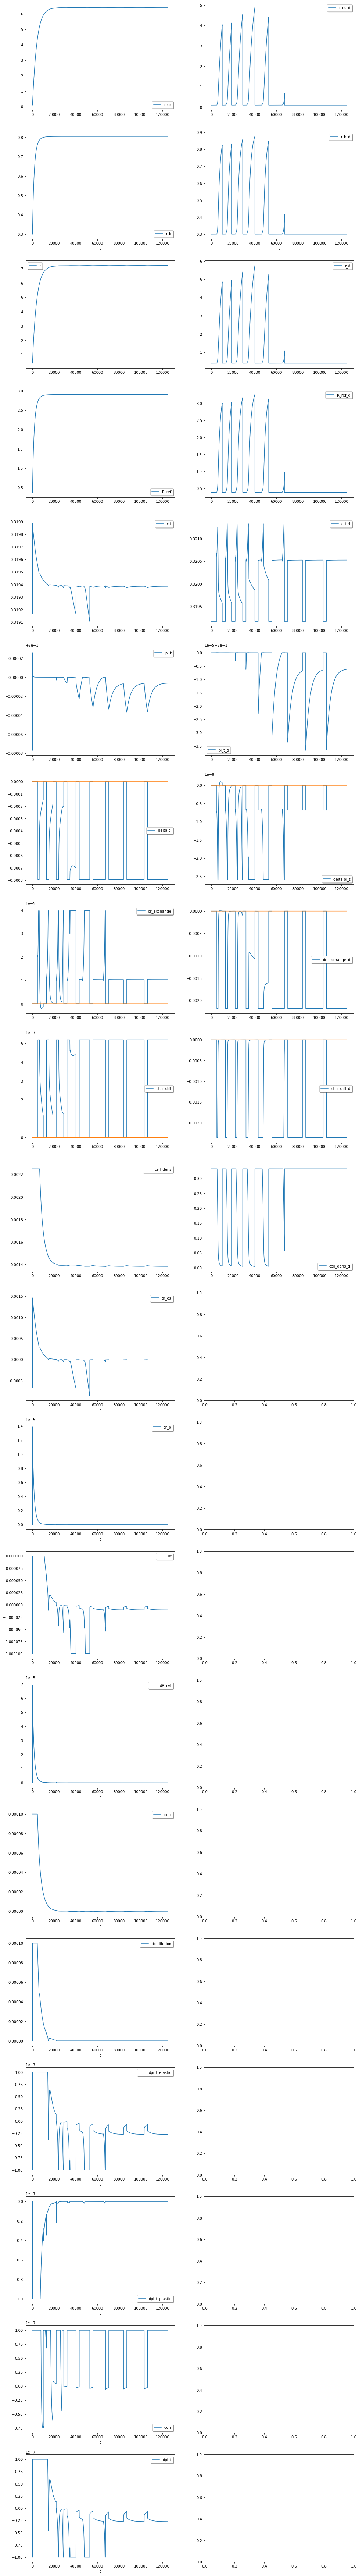

In [99]:
#plotting

fig,ax = plt.subplots(20,2,figsize=(16,128))
ax[0,0].plot(res_t,res_y[0])
ax[1,0].plot(res_t, res_y[1])
ax[2,0].plot(res_t, res_y[2])
ax[3,0].plot(res_t, res_y[3])
ax[4,0].plot(res_t, res_y[4])
ax[5,0].plot(res_t, res_y[5])
ax[0,1].plot(res_t, res_y[6])
ax[1,1].plot(res_t, res_y[7])
ax[2,1].plot(res_t, res_y[8])
ax[3,1].plot(res_t, res_y[9])
ax[4,1].plot(res_t, res_y[10])
ax[5,1].plot(res_t, res_y[11])
ax[6,0].plot(res_t,delta_ci)
ax[6,0].plot(res_t,zero)
ax[6,1].plot(res_t,delta_pi_t)
ax[6,1].plot(res_t,zero)
ax[7,0].plot(res_t,dr_exchange)
ax[7,0].plot(res_t,zero)
ax[7,1].plot(res_t,dr_exchange_d)
ax[7,1].plot(res_t,zero)
ax[8,0].plot(res_t,dc_diff)
ax[8,0].plot(res_t,zero)
ax[8,1].plot(res_t,dc_diff_d)
ax[8,1].plot(res_t,zero)
ax[9,0].plot(res_t,cell_dens)
ax[9,1].plot(res_t,cell_dens_d)
ax[10,0].plot(res_t,res_dr_os)
ax[11,0].plot(res_t,res_dr_b)
ax[12,0].plot(res_t,res_dr)
ax[13,0].plot(res_t,res_dR_ref)
ax[14,0].plot(res_t,res_dn_i)
ax[15,0].plot(res_t,res_dc_dilution)
ax[16,0].plot(res_t,res_dpi_t_elastic)
ax[17,0].plot(res_t,res_dpi_t_plastic)
ax[18,0].plot(res_t,res_dc_i)
ax[19,0].plot(res_t,res_dpi_t)


ax[0,0].set_xlabel('t')
ax[1,0].set_xlabel('t')
ax[2,0].set_xlabel('t')
ax[2,0].set_xlabel('t')
ax[3,0].set_xlabel('t')
ax[4,0].set_xlabel('t')
ax[5,0].set_xlabel('t')
ax[1,1].set_xlabel('t')
ax[2,1].set_xlabel('t')
ax[3,1].set_xlabel('t')
ax[4,1].set_xlabel('t')
ax[5,1].set_xlabel('t')
ax[6,0].set_xlabel('t')
ax[6,1].set_xlabel('t')
ax[7,0].set_xlabel('t')
ax[7,1].set_xlabel('t')
ax[8,0].set_xlabel('t')
ax[8,1].set_xlabel('t')
ax[9,0].set_xlabel('t')
ax[9,1].set_xlabel('t')
ax[10,0].set_xlabel('t')
ax[11,0].set_xlabel('t')
ax[12,0].set_xlabel('t')
ax[13,0].set_xlabel('t')
ax[14,0].set_xlabel('t')
ax[15,0].set_xlabel('t')
ax[16,0].set_xlabel('t')
ax[17,0].set_xlabel('t')
ax[18,0].set_xlabel('t')
ax[19,0].set_xlabel('t')

ax[0,0].legend(['r_os'], shadow=True)
ax[1,0].legend(['r_b'], shadow=True)
ax[2,0].legend(['r'], shadow=True)
ax[3,0].legend(['R_ref'], shadow=True)
ax[4,0].legend(['c_i'], shadow=True)
ax[5,0].legend(['pi_t'], shadow=True)
ax[0,1].legend(['r_os_d'], shadow=True)
ax[1,1].legend(['r_b_d'], shadow=True)
ax[2,1].legend(['r_d'], shadow=True)
ax[3,1].legend(['R_ref_d'], shadow=True)
ax[4,1].legend(['c_i_d'], shadow=True)
ax[5,1].legend(['pi_t_d'], shadow=True)
ax[6,0].legend(['delta ci'], shadow=True)
ax[6,1].legend(['delta pi_t'], shadow=True)
ax[7,0].legend(['dr_exchange'], shadow=True)
ax[7,1].legend(['dr_exchange_d'], shadow=True)
ax[8,0].legend(['dc_i_diff'], shadow=True)
ax[8,1].legend(['dc_i_diff_d'], shadow=True)
ax[9,0].legend(['cell_dens'], shadow=True)
ax[9,1].legend(['cell_dens_d'], shadow=True)
ax[10,0].legend(['dr_os'], shadow=True)
ax[11,0].legend(['dr_b'], shadow=True)
ax[12,0].legend(['dr'], shadow=True)
ax[13,0].legend(['dR_ref'], shadow=True)
ax[14,0].legend(['dn_i'], shadow=True)
ax[15,0].legend(['dc_dilution'], shadow=True)
ax[16,0].legend(['dpi_t_elastic'], shadow=True)
ax[17,0].legend(['dpi_t_plastic'], shadow=True)
ax[18,0].legend(['dc_i'], shadow=True)
ax[19,0].legend(['dpi_t'], shadow=True)


plt.show()
